In [1]:
import torch
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.filters import gaussian
from skimage.util import random_noise

In [2]:
def load_vgg16_feature_extractor():
    """
    Load the VGG16 model's feature extractor (up to the selected layers).
    """
    feature_extractor = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
    selected_layers = [2, 7, 12, 21, 30]
    for param in feature_extractor.parameters():
        param.requires_grad = False
    return feature_extractor, selected_layers

def load_alexnet_feature_extractor():
    """
    Load the AlexNet model's feature extractor (up to the selected layers).
    """
    feature_extractor = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).features
    selected_layers = [0, 3, 6, 8, 10]
    for param in feature_extractor.parameters():
        param.requires_grad = False
    return feature_extractor, selected_layers

In [3]:
def lpips_loss(img1: torch.Tensor, img2: torch.Tensor, model_type: str = 'vgg') -> torch.Tensor:
    """
    Computes the Learned Perceptual Image Patch Similarity (LPIPS) loss.
    """
    # Load the appropriate feature extractor
    if model_type == 'vgg':
        feature_extractor, selected_layers = load_vgg16_feature_extractor()
    elif model_type == 'alex':
        feature_extractor, selected_layers = load_alexnet_feature_extractor()
    else:
        raise ValueError("Unsupported model type. Choose 'vgg' or 'alex'.")

    feature_extractor.eval()

    # Ensure inputs are in float32
    img1 = img1.float()
    img2 = img2.float()

    features1 = []
    features2 = []

    for idx, layer in enumerate(feature_extractor):
        img1 = layer(img1)
        img2 = layer(img2)

        if idx in selected_layers:
            features1.append(img1)
            features2.append(img2)

    lpips_loss = 0.0
    for feat1, feat2 in zip(features1, features2):
        feat1 = F.normalize(feat1, dim=1)
        feat2 = F.normalize(feat2, dim=1)
        lpips_loss += torch.mean((feat1 - feat2) ** 2)

    return lpips_loss

In [4]:
def psnr(img1: torch.Tensor, img2: torch.Tensor, max_val: float = 1.0) -> float:
    """
    Computes the Peak Signal-to-Noise Ratio (PSNR) between two images.
    """
    mse = F.mse_loss(img1, img2)
    psnr_value = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr_value.item()

In [5]:
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img_as_float(img)
    return torch.tensor(img).permute(2, 0, 1).float()

In [6]:
def apply_blur(image):
    blurred = gaussian(image.permute(1, 2, 0).numpy(), sigma=3, channel_axis=-1)
    return torch.tensor(blurred).permute(2, 0, 1)

def apply_noise(image):
    noisy = random_noise(image.permute(1, 2, 0).numpy(), mode='gaussian', var=0.01)
    return torch.tensor(noisy).permute(2, 0, 1).clamp(0, 1)

def apply_jitter(image):
    shift = 5
    jittered = torch.roll(image, shifts=shift, dims=2)
    return jittered

def apply_all_random(image):
    return apply_jitter(apply_noise(apply_blur(image)))


In [7]:
def compute_ssim(image1, image2):
    return ssim(
        image1.permute(1, 2, 0).numpy(),
        image2.permute(1, 2, 0).numpy(),
        multichannel=True,
        channel_axis=-1,
        win_size=3,
        data_range=1.0  # Specify the data_range
    )

In [8]:
def main():
    image_path = "image.png"  # Replace with the path to your image
    original = load_image(image_path)

    degraded_images = {
        "blurred": apply_blur(original),
        "noisy": apply_noise(original),
        "jittered": apply_jitter(original),
        "all_random": apply_all_random(original),
    }

    print("Metrics:")
    # Compare original vs original
    psnr_original = psnr(original, original, max_val=1.0)
    ssim_original = compute_ssim(original, original)
    lpips_original = lpips_loss(original.unsqueeze(0), original.unsqueeze(0)).item()

    print(f"Original vs Original - PSNR: {psnr_original:.2f}, SSIM: {ssim_original:.4f}, LPIPS: {lpips_original:.4f}")

    # Compare degraded images
    for name, transformed in degraded_images.items():
        psnr_value = psnr(original, transformed, max_val=1.0)
        ssim_value = compute_ssim(original, transformed)
        lpips_value = lpips_loss(original.unsqueeze(0), transformed.unsqueeze(0)).item()

        print(f"{name.capitalize()} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, LPIPS: {lpips_value:.4f}")

    # Display images using matplotlib
    fig, axes = plt.subplots(1, len(degraded_images) + 1, figsize=(15, 5))
    axes[0].imshow(original.permute(1, 2, 0).numpy())
    axes[0].set_title("Original")
    axes[0].axis("off")

    for i, (name, transformed) in enumerate(degraded_images.items(), start=1):
        axes[i].imshow(transformed.permute(1, 2, 0).numpy())
        axes[i].set_title(name.capitalize())
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

Metrics:
Original vs Original - PSNR: inf, SSIM: 1.0000, LPIPS: 0.0000
Blurred - PSNR: 23.53, SSIM: 0.7536, LPIPS: 0.0130
Noisy - PSNR: 20.19, SSIM: 0.2498, LPIPS: 0.0226
Jittered - PSNR: 16.72, SSIM: 0.5356, LPIPS: 0.0183
All_random - PSNR: 16.32, SSIM: 0.0985, LPIPS: 0.0351


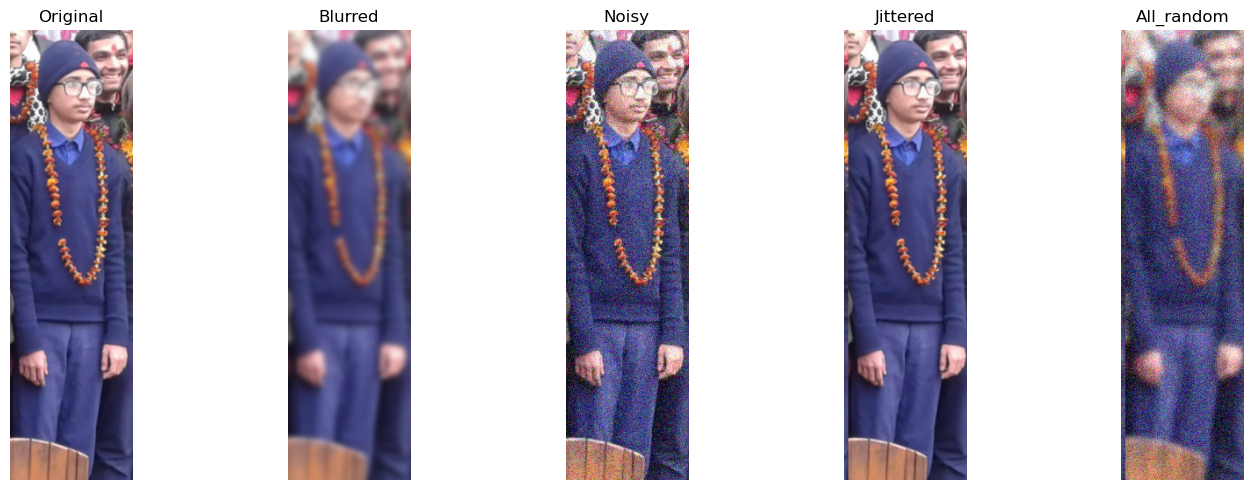

In [9]:
if __name__ == "__main__":
    main()